In [1]:
import os
from IPython.display import HTML
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
import numpy as np
from typing import Iterable
from pyciemss.utils.interface_utils import (
    assign_interventions_to_timepoints,
    interventions_and_sampled_params_to_interval,
    convert_to_output_format
)
from pyciemss.utils import get_tspan
import matplotlib.pyplot as plt
import torch
from torch import tensor

Plotting utils

In [2]:
COLORS=['red','green','blue','black','gold','purple','orangered']
# TODO: Add plot title, axis labels

def plot_allsolns(samples_df, title):
    QoIs = ["D_sol", "E_sol", "I_sol", "R_sol", "S_sol"]
    QoI_samples = {key: None for key in QoIs}
    for QoI in QoIs:
        # Aggregate results
        total_pop = samples_df[samples_df["sample_id"] == 0]["S_sol"].to_numpy()[0]
        QoI_samples[QoI] = [samples_df[samples_df["sample_id"] == i][QoI].to_numpy()/total_pop * 100 for i in range(num_samples)]
    # Plot median of all QoIs
    fig, ax = plt.subplots()
    for i, QoI in enumerate(QoIs):
        ax.plot(timepoints, np.percentile(QoI_samples[QoI], 50, axis=0), color=COLORS[i], label=QoI)
        ax.set_title(title)
        ax.legend()

# SCENARIO 1: Forecasting with non-pharmaceutical interventions (NPIs) such as, masking and social distancing. 

**"You want to implement a masking intervention in a simple compartmental model and simulate epidemic trajectories under different compliance scenarios. You found an existing model that incorporates masking as a time-dependent modification to the $\beta$ parameter, and you want to ensure that the model is working as expected by reproducing plots in the publication"**

### PART 1
**(A)** TA1/TA2 provide the AMR for a COVID-19 model with compartments SEIRD (Susceptible, Exposed, Infected, Recovered, Death) and, importantly, a time-dependent transmission rate $\beta$. A mask order may be implemented $t_0$ days after the first case is detected (at time $t = 0$), and $\beta$ varies in time according to the effectiveness of the NPI under various levels of compliance.\
Transmission rate $\beta(t)$ is defined as, \begin{align} \beta(t) &= \kappa m(t) \\
m(t) &= \beta_c + \frac{\beta_s - \beta_c}{1 + e^{-k (t_0 - t)}},
\end{align}
where $\kappa$ is an arbitrary constant, and $m(t)$ represents adoption of a mask order $t_0$ days after the first case is detected, assuming 100% compliance. \
Model Source: https://doi.org/10.3390/ijerph18179027 \
AMR location: https://github.com/indralab/mira/blob/hackathon/notebooks/hackathon_2023.07/scenario1_a.json 

*Temporarily, please use the alternative AMR (scenario1_constant_beta.json) located here: https://github.com/ciemss/pyciemss/tree/sa_hackathon_prep/notebook/hackathon_prep, which has a CONSTANT $\beta$.*

Model Schematic:

<div>
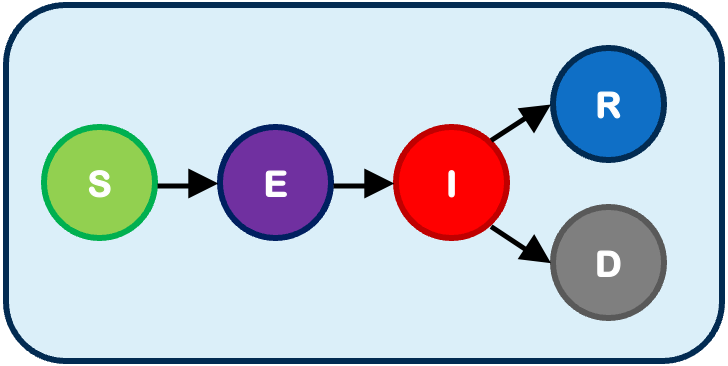
</div>

In [3]:
DEMO_PATH = "scenario1.ipynb"
SEIRD_model_path = "scenario1_constant_beta.json"
#SEIRD_model_path = "scenario1_constant_beta_try_again.json"
# "https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/main/petrinet/examples/sir_typed.json"

**(B) TA3 TASK 1:** Perform model simulation with various delays ($t_0$ values) in mask order implementation, and reproduce Fig. 3, including peak prevalence estimates. 
<div>
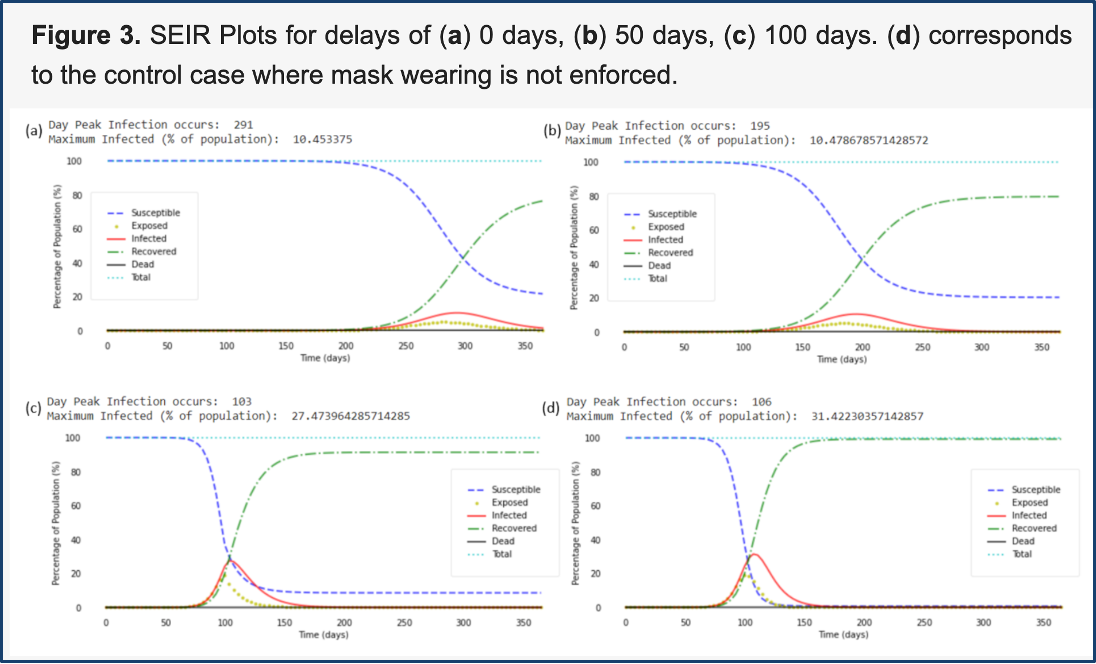
</div>

Control Case

In [4]:
num_samples = 1
start_time = 0
end_time = 365
num_timepoints = (end_time-start_time)*10 + 1
timepoints = get_tspan(start_time, end_time, num_timepoints)
# TODO: Add intervention to set beta value as 1.
# Run sampling w/o an intervention
control_samples = load_and_sample_petri_model(SEIRD_model_path, num_samples, timepoints=timepoints)

Delayed Masking Implementation

Modifying modified logistic function ($m(t)$ in the paper)

Used to model this transition by setting the infection rate before and after implementing mask mandate assuming 100% compliance.

In [5]:
def modify_logistic_func(t, t0=0, k=1, beta_c=0.4, beta_s=1):
    return beta_c + (beta_s-beta_c)/(1+np.exp(-1*k*(t0-t)))

Acquire array of betas for intervention according to  $\beta(t) = \kappa m(t)$

Note: In order to intervene on a distribution of $\beta$ values, randomly sampled values of $\beta_s$ can be passed in respectively

In [6]:
def get_intervention_betas(start_intervene_day, start_day, end_day, kappa=1, beta_s=1, beta_c=0.4):
    intervention_time = np.arange(start_day,end_day+1) + 1e-6
    m = [modify_logistic_func(t,t0=start_intervene_day) for t in intervention_time]
    intervened_beta_values = kappa*m
    return [(intervention_time[i], 'beta_s', intervened_beta_values[i]) for i in range(len(intervention_time))]

Reproduction of figure 1 from the paper

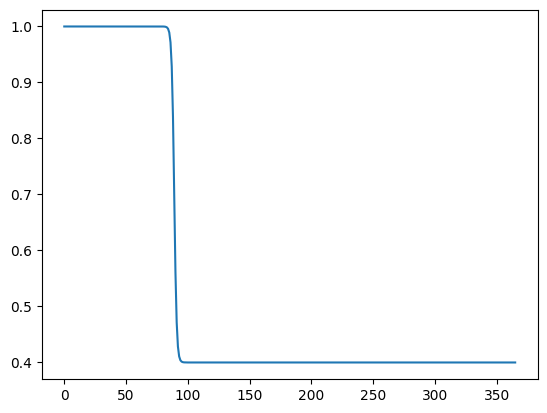

In [7]:
intervention_time = np.arange(start_time,end_time+1)
m = [modify_logistic_func(t,t0=89) for t in intervention_time]
plt.plot(intervention_time, m)

Figure 3 Recreation

Case A - 0 Days Delay of Mask Mandate

In [8]:
intervened_betas = get_intervention_betas(start_intervene_day=0, start_day=start_time, end_day=end_time)
implement_0day_samples = load_and_sample_petri_model(
    SEIRD_model_path, num_samples, timepoints=timepoints, interventions=intervened_betas
)

Case B - 50 Days Delay of Mask Mandate

In [9]:
intervened_betas = get_intervention_betas(start_intervene_day=50, start_day=start_time, end_day=end_time)
implement_50day_samples = load_and_sample_petri_model(
    SEIRD_model_path, num_samples, timepoints=timepoints, interventions=intervened_betas
)

Case C - 100 Days Delay of Mask Mandate

In [10]:
intervened_betas = get_intervention_betas(start_intervene_day=100, start_day=start_time, end_day=end_time)
implement_100day_samples = load_and_sample_petri_model(
    SEIRD_model_path, num_samples, timepoints=timepoints, interventions=intervened_betas
)

In [20]:
implement_100day_samples.isnull().values.any()


False

Case D - Control (no intervention)

In [12]:
intervened_betas = [(1e-6,'beta_s',1)]
control_samples = load_and_sample_petri_model(
    SEIRD_model_path, num_samples, timepoints=timepoints, interventions=intervened_betas
)

In [13]:
control_samples2 = load_and_sample_petri_model(
    SEIRD_model_path, num_samples, timepoints=timepoints)

In [14]:
control_samples2

,timepoint_id,sample_id,N_param,beta_s_param,kappa_param,"('S', 'E', 'E', 'ControlledConversion', 'rate')_param",mira_param_0_param,mira_param_1_param,mira_param_2_param,D_sol,E_sol,I_sol,R_sol,S_sol
0,0,0,5489756.0,0.953959,0.42752,0.561532,0.207995,0.082395,0.000007,7.616581e-27,1.000000e+00,2.079946e-11,8.568798e-23,5.599999e+06
1,1,0,5489756.0,0.953959,0.42752,0.561532,0.207995,0.082395,0.000007,7.686104e-09,1.035986e+00,2.108502e-02,8.647008e-05,5.599999e+06
2,2,0,5489756.0,0.953959,0.42752,0.561532,0.207995,0.082395,0.000007,3.102772e-08,1.073267e+00,4.275578e-02,3.490676e-04,5.599999e+06
3,3,0,5489756.0,0.953959,0.42752,0.561532,0.207995,0.082395,0.000007,7.046203e-08,1.111890e+00,6.503478e-02,7.927106e-04,5.599999e+06
4,4,0,5489756.0,0.953959,0.42752,0.561532,0.207995,0.082395,0.000007,1.264430e-07,1.151901e+00,8.794533e-02,1.422506e-03,5.599999e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,3646,0,5489756.0,0.953959,0.42752,0.561532,0.207995,0.082395,0.000007,4.557012e+02,1.904082e-16,3.329172e-05,5.126719e+06,4.728248e+05
3647,3647,0,5489756.0,0.953959,0.42752,0.561532,0.207995,0.082395,0.000007,4.557012e+02,1.873708e-16,3.301849e-05,5.126719e+06,4.728248e+05
3648,3648,0,5489756.0,0.953959,0.42752,0.561532,0.207995,0.082395,0.000007,4.557012e+02,1.843832e-16,3.274758e-05,5.126719e+06,4.728248e+05
3649,3649,0,5489756.0,0.953959,0.42752,0.561532,0.207995,0.082395,0.000007,4.557012e+02,1.814427e-16,3.247882e-05,5.126719e+06,4.728248e+05


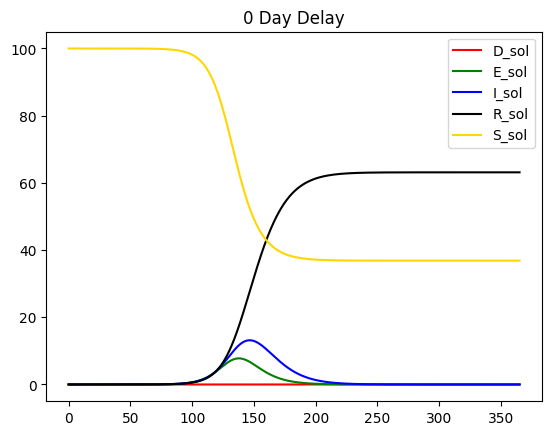

In [15]:
plot_allsolns(implement_0day_samples, "0 Day Delay")

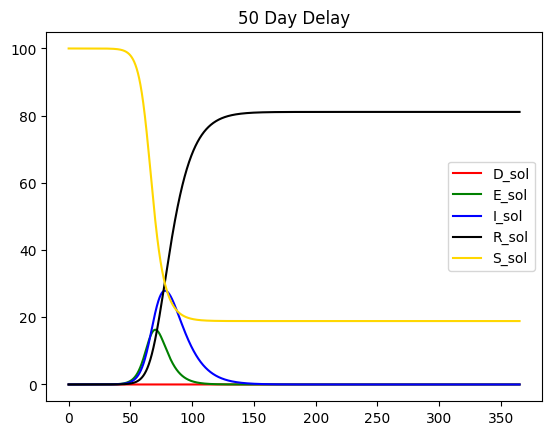

In [16]:
plot_allsolns(implement_50day_samples, "50 Day Delay")

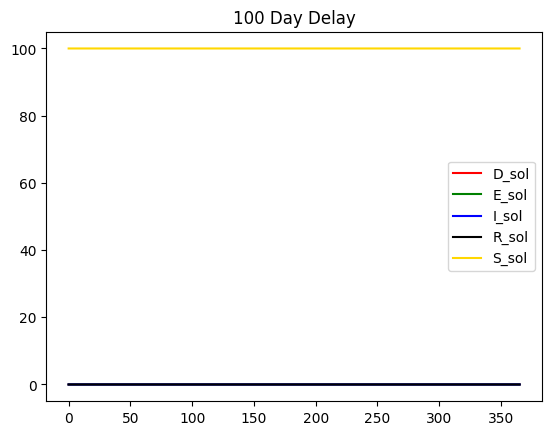

In [17]:
plot_allsolns(implement_100day_samples, "100 Day Delay")

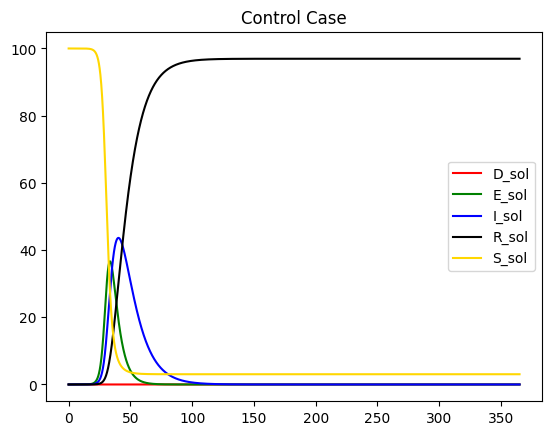

In [18]:
plot_allsolns(control_samples, "Control Case")

NameError: name 'QoIs' is not defined

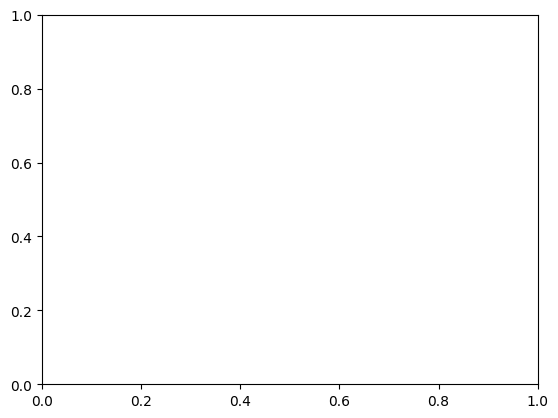

In [19]:
# Plot fill-between of all QoIs
fig, ax = plt.subplots()
for i, QoI in enumerate(QoIs):
    ax.fill_between(timepoints, np.percentile(QoI_samples[QoI], 25, axis=0), np.percentile(QoI_samples[QoI], 75, axis=0), color=COLORS[i], alpha=0.5)
    ax.plot(timepoints, np.percentile(QoI_samples[QoI], 50, axis=0), color=COLORS[i], label=QoI)
    ax.legend()

In [ ]:
# Plot median of all QoIs
fig, ax = plt.subplots()
for i, QoI in enumerate(QoIs):
    ax.plot(timepoints, np.percentile(QoI_samples[QoI], 50, axis=0), color=COLORS[i], label=QoI)
    ax.legend()

**(C)** TA2 updates the AMR to redefine $\beta(t)$ as, \begin{align} \beta(t) &= \kappa m(t) \\
m(t) &= \beta_{nc} + \frac{\beta_s - \beta_c}{1 + e^{-k_1(t_0 - t)}} + \frac{\beta_c - \beta_{nc}}{1 + e^{-k_2(t_1 - t)}}, \end{align}
to model gradual non-compliance with a mask order. \
AMR location: https://github.com/indralab/mira/blob/hackathon/notebooks/hackathon_2023.07/scenario1_c.json 

**TA3 TASK 2:** Perform model simulation over a range of delays in mask enforcement, and plot the peak prevalence to reproduce Fig. 5.
<div>
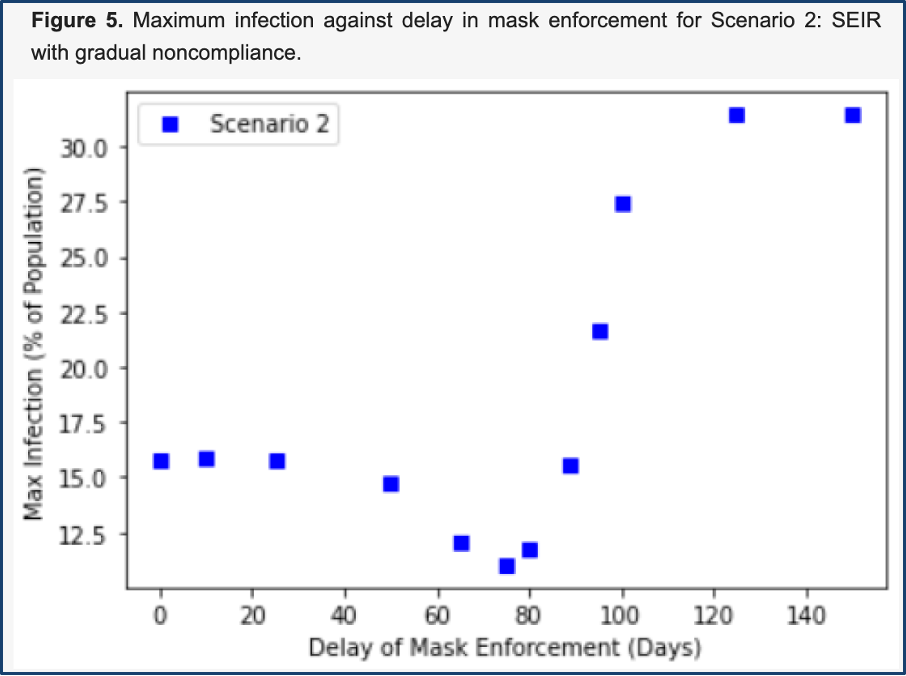
</div>

**(D)** TA2 updates AMR of SEIRD model to include possibility for reinfection, producing the SEIRS model.
AMR location: https://github.com/indralab/mira/blob/hackathon/notebooks/hackathon_2023.07/scenario1_d.json \
Model Schematic:
<div>
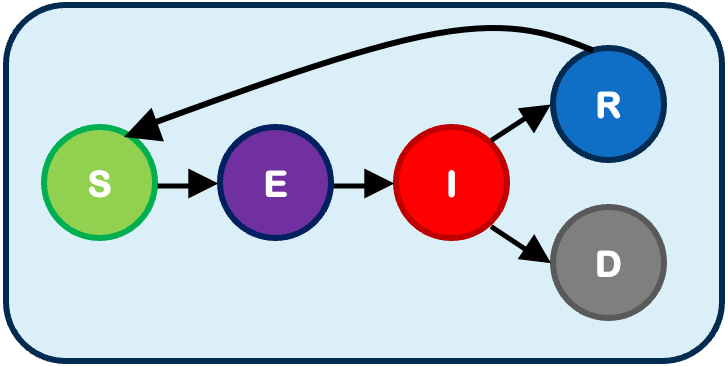
</div>

**TA3 TASK 3:** Perform model simulation and again reproduce Fig. 5 (as in TASK 2). Compare with previous results (as in 1C), "what impact does immunity loss and potential for reinfection have?"

**(E) TA3 TASK 4:** Repeat the previous SEIRS model simulation (as in TASK 3), but add *uncertainty* by assessing a range of non-compliance levels (as defined by $\beta_{nc}$ and $k_2$) and reinfection rates (as controlled through $\epsilon$). Plot the state variables over time along with the uncertainty ranges.

### PART 2
**(D) TA3 Recommended TASK 5:** Find a real-world example of a mask order being implemented. Calibrate the model from Part 1A using data from the COVID-19 ForecastHub for a period before the mask intervention is implemented, and forecast through the intervention period. Demonstrate how the forecast varies based on compliance rates.